<a href="https://colab.research.google.com/github/harshit57709/Self-Driving-Car/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/harshit57709/Self-Driving-Car


Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 3527, done.
remote: Counting objects: 100% (3527/3527), done.
remote: Compressing objects: 100% (3526/3526), done.
remote: Total 18752 (delta 0), reused 3525 (delta 0), pack-reused 15225
Receiving objects: 100% (18752/18752), 236.51 MiB | 14.93 MiB/s, done.
Checking out files: 100% (18895/18895), done.


In [ ]:
!ls Self-Driving-Car/data

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as npimg
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D,Convolution2D, Dropout
from keras.optimizers import Adam
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [ ]:
datadir = "Self-Driving-Car/data"

In [ ]:
columns = ["center","left","right","steering","throttle","reverse","speed"]
data = pd.read_csv(os.path.join(datadir,"driving_log.csv" ), names = columns,index_col=False)
pd.set_option("display.max_colwidth",-1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


center  ...     speed
0  C:\Users\Harshit\Desktop\simulator\data\IMG\center_2020_05_08_08_57_02_026.jpg  ...  0.000078
1  C:\Users\Harshit\Desktop\simulator\data\IMG\center_2020_05_08_08_57_02_131.jpg  ...  0.000078
2  C:\Users\Harshit\Desktop\simulator\data\IMG\center_2020_05_08_08_57_02_231.jpg  ...  0.000078
3  C:\Users\Harshit\Desktop\simulator\data\IMG\center_2020_05_08_08_57_02_335.jpg  ...  0.000078
4  C:\Users\Harshit\Desktop\simulator\data\IMG\center_2020_05_08_08_57_02_439.jpg  ...  0.000078

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [ ]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2020_05_08_08_57_02_026.jpg  ...  0.000078
1  center_2020_05_08_08_57_02_131.jpg  ...  0.000078
2  center_2020_05_08_08_57_02_231.jpg  ...  0.000078
3  center_2020_05_08_08_57_02_335.jpg  ...  0.000078
4  center_2020_05_08_08_57_02_439.jpg  ...  0.000078

[5 rows x 7 columns]

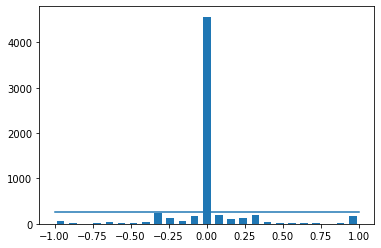

In [ ]:
num_bins = 25
samples_per_bin = 250
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * .5
plt.bar(center, hist, width=0.05)
plt.plot([min(data['steering']), max(data['steering'])],[samples_per_bin, samples_per_bin])

clearly data is very baised towards zero angle


In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print("removed", len(remove_list))
data.drop(data.index[remove_list], inplace = True)

removed 4316


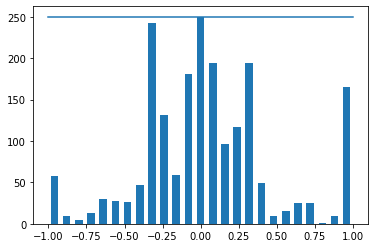

In [ ]:
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot([min(data['steering']), max(data['steering'])],[samples_per_bin, samples_per_bin])

In [ ]:
def load_img_steering(datadir):
  image_path=[]
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering   = np.asarray(steering)
  return image_path, steering
image_paths, steerings = load_img_steering(datadir+ "/IMG" )

In [ ]:
X_train, X_valid, y_train, y_valid = tts(image_paths, steerings, test_size=0.2, random_state=0)

Text(0.5, 1.0, 'validation_set')

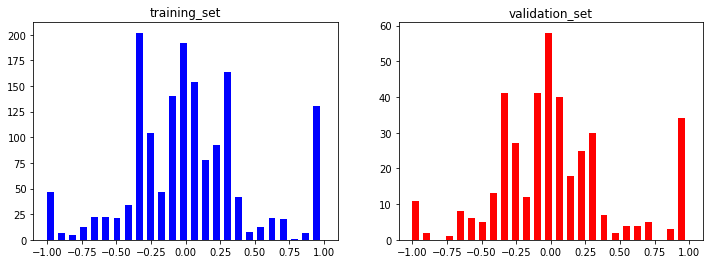

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title("training_set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title("validation_set")

In [ ]:
def zoom(image):
  zoom  = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

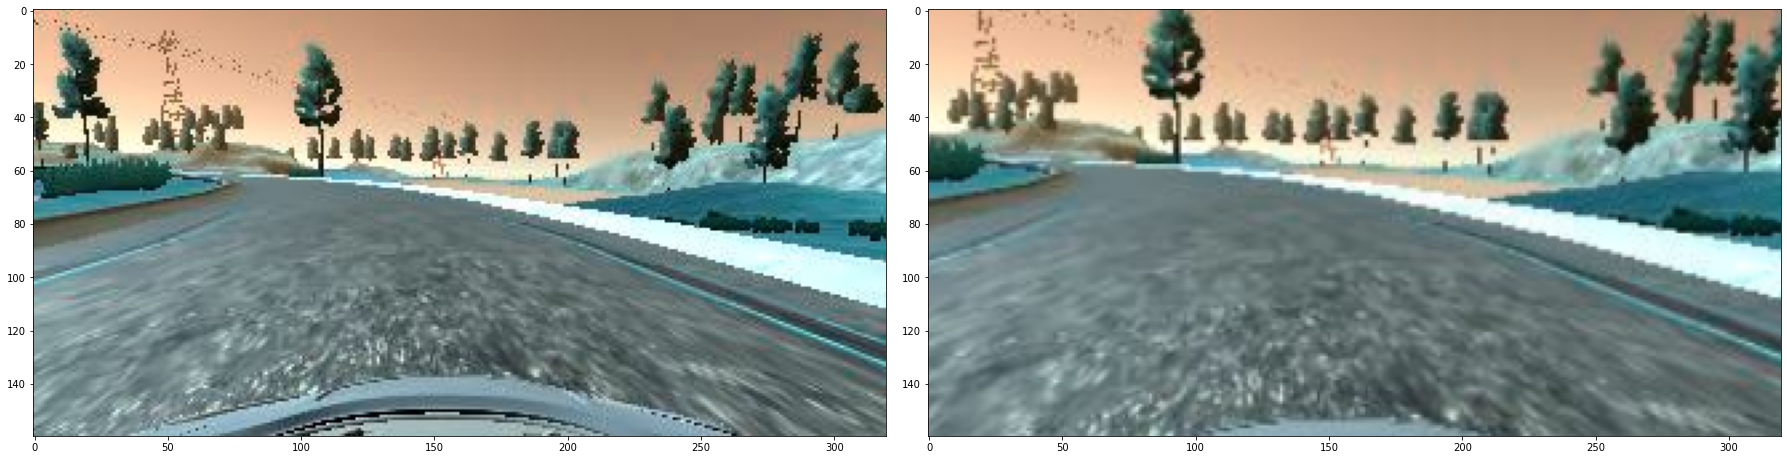

In [ ]:
image = image_paths[random.randint(0,1000)]
original = cv2.imread(image)
zoomed   = zoom(original)

fig, axs =plt.subplots(1, 2, figsize= (25, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[1].imshow(zoomed)

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent ={"x": [-0.1, 0.1],"y": [-.1, .1] })
  image = pan.augment_image(image)
  return image

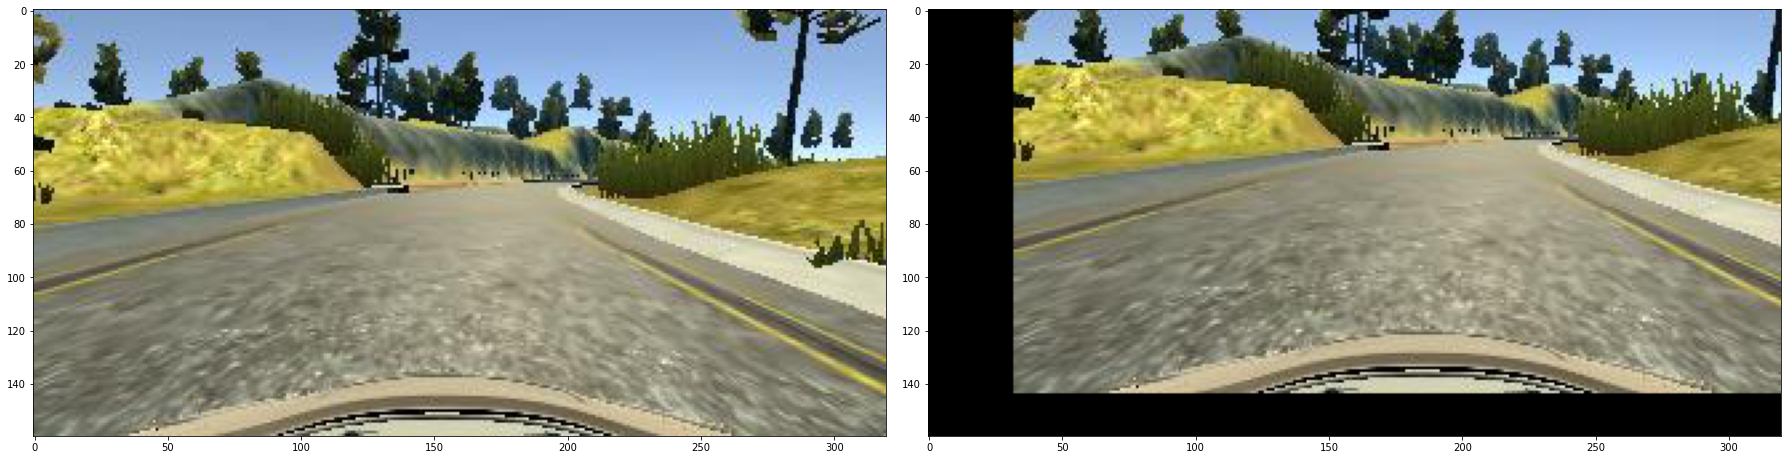

In [ ]:
image = image_paths[random.randint(0,1000)]
original = npimg.imread(image)
panned  = pan(original)

fig, axs =plt.subplots(1, 2, figsize= (25, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[1].imshow(panned)

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply([0.2, 1.2])
  image = brightness.augment_image(image)
  return image

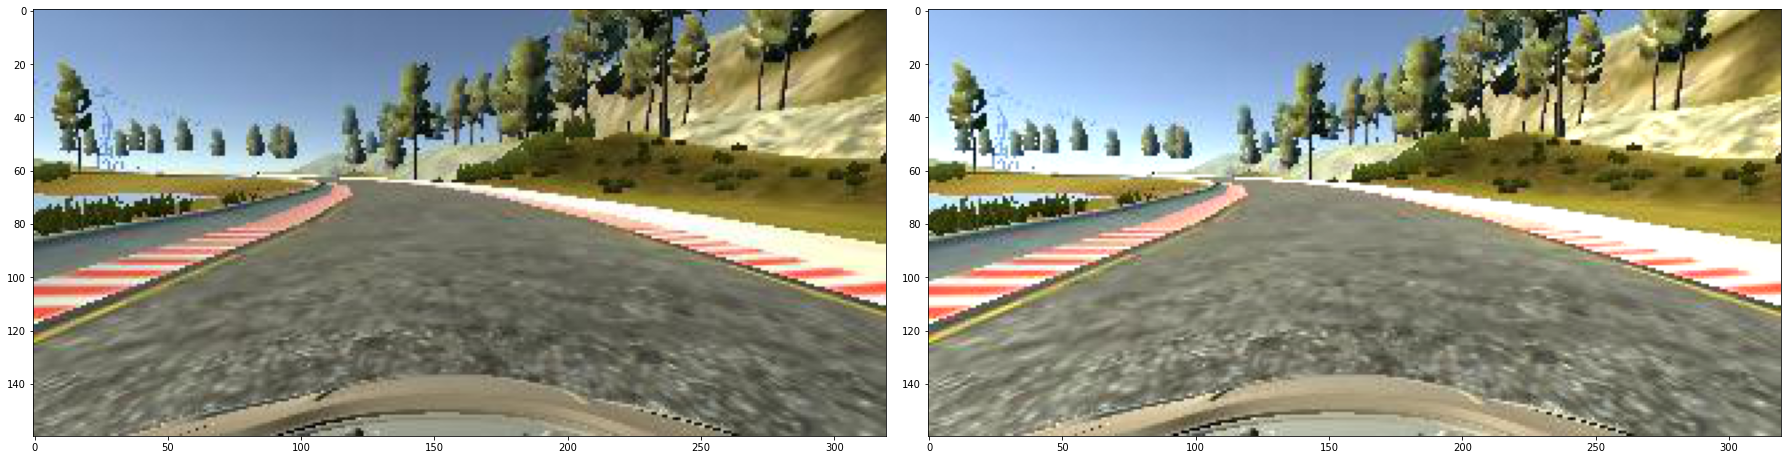

In [ ]:

original = npimg.imread(image)
brightness_altered  =img_random_brightness(original)

fig, axs =plt.subplots(1, 2, figsize= (25, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[1].imshow(brightness_altered)

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

-0.05767711
0.05767711


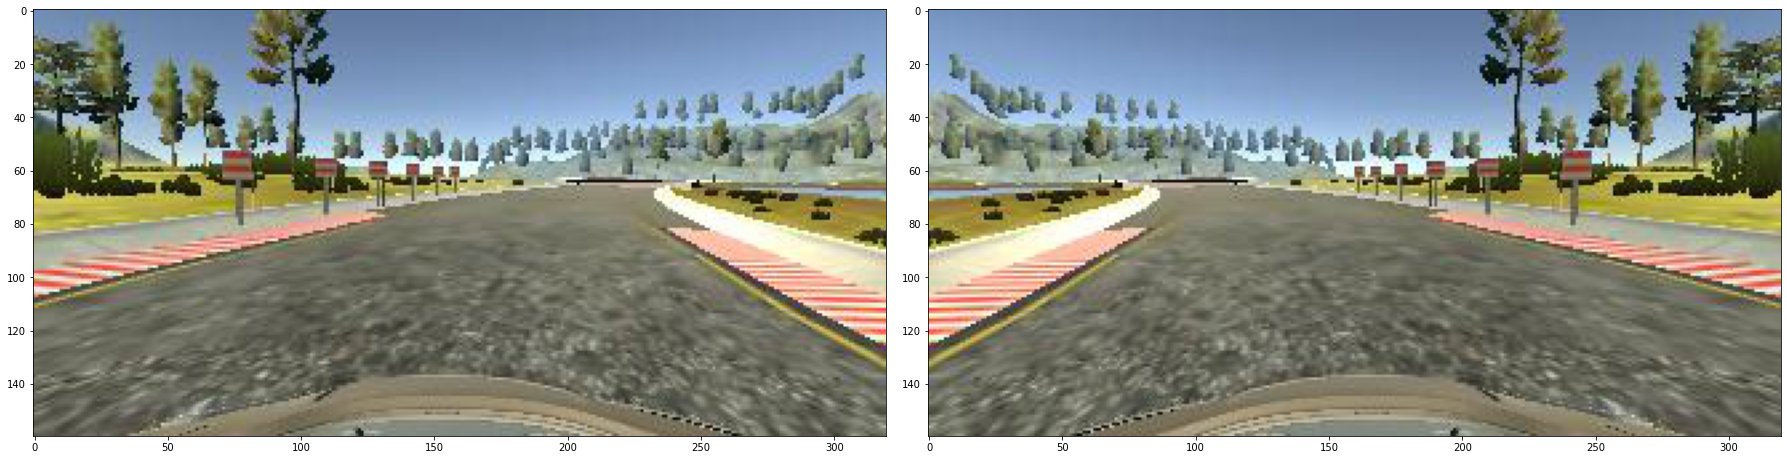

In [ ]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original = npimg.imread(image)
flipped, new  = img_random_flip(original, steering_angle)

fig, axs =plt.subplots(1, 2, figsize= (25, 10))
fig.tight_layout()
axs[0].imshow(original)
axs[1].imshow(flipped)
print(new)
print(steering_angle)

In [ ]:
def random_augment(image, steering_angle):
  image = npimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

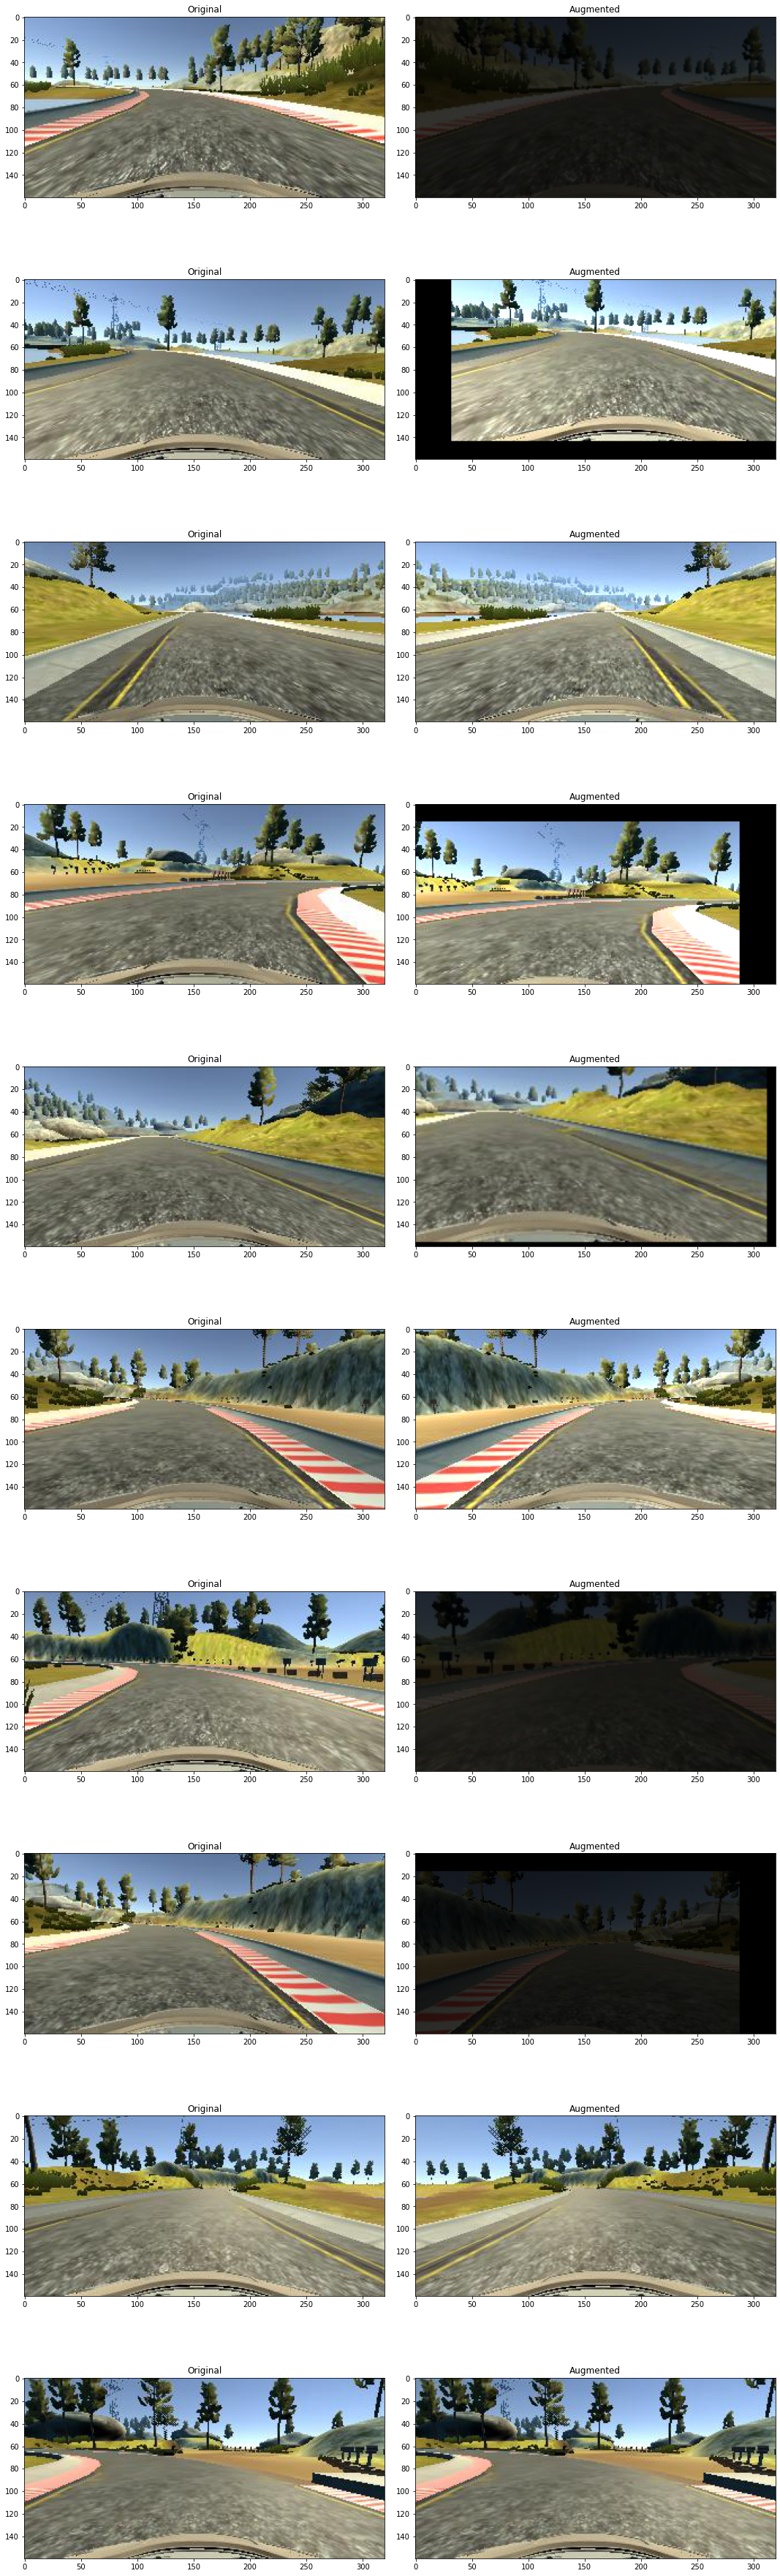

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize =(15, 50))
fig.tight_layout()

for i in range(nrow):
  random_index = random.randint(0,1000)
  image = image_paths[random_index]
  steering_angle = steerings[random_index]

  original_image = npimg.imread(image)
  augmented_image, steering_angle = random_augment(image, steering_angle)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented")


In [ ]:
def img_preprocessing(img):
  # img = npimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [ ]:
# image = image_paths[100]
# original_image = npimg.imread(image)
# preprocessed_image = img_preprocessing(image)

# fig, axes = plt.subplots(1, 2, figsize=(25, 20))
# fig.tight_layout()
# axes[0].imshow(original_image)
# axes[0].set_title("original Image")
# axes[1].imshow(preprocessed_image)
# axes[1].set_title("preprocessed_image")

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while 1:
    batch_img = []
    batch_steering =[]
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining:
        im, steering= random_augment(image_paths[random_index], steering_ang[random_index] )
      else:
        im = npimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


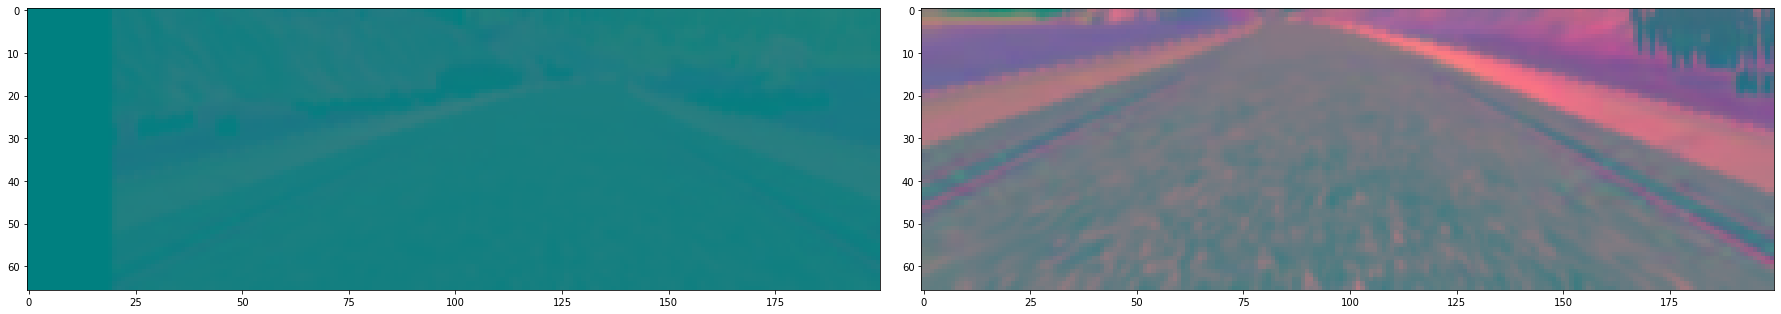

In [ ]:
X_train_gen , y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_valid_gen , y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
fig, axs =plt.subplots(1, 2, figsize= (25, 10))
fig.tight_layout()
axs[0].imshow(X_train_gen[0])
axs[1].imshow(X_valid_gen[0])

we clearly dont need to top of image showing the scenery and very bottom of image showing just the hood

In [ ]:
X_train = np.array(list(map(img_preprocessing, X_train)))
X_valid = np.array(list(map(img_preprocessing, X_valid)))

TypeError: ignored

TypeError: ignored

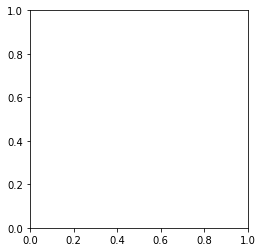

In [ ]:
plt.imshow(X_valid[67])
X_valid[67].shape

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2),input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides = (2, 2), activation="elu"))
  model.add(Convolution2D(48, (5, 5), strides = (2, 2), activation="elu"))
  model.add(Convolution2D(64, (3, 3), activation="elu"))
  model.add(Convolution2D(64, (3, 3), activation="elu"))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation= "elu"))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation= "elu"))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation= "elu"))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))

  model.compile(loss="mse", optimizer=Adam(lr=1e-3))
  return model

In [ ]:
model = nvidia_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train,100,1),steps_per_epoch=300, epochs=10, validation_data= batch_generator(X_valid, y_valid,100, 0), validation_steps=200, verbose= 1, shuffle=1)

Epoch 1/10
300/300 [==============================] - 224s 746ms/step - loss: 0.2650 - val_loss: 0.1137
Epoch 2/10
300/300 [==============================] - 217s 722ms/step - loss: 0.1718 - val_loss: 0.1371
Epoch 3/10
300/300 [==============================] - 210s 702ms/step - loss: 0.1646 - val_loss: 0.1013
Epoch 4/10
300/300 [==============================] - 209s 698ms/step - loss: 0.1596 - val_loss: 0.1169
Epoch 5/10
300/300 [==============================] - 216s 718ms/step - loss: 0.1549 - val_loss: 0.1358
Epoch 6/10
300/300 [==============================] - 216s 721ms/step - loss: 0.1530 - val_loss: 0.1128
Epoch 7/10
300/300 [==============================] - 216s 721ms/step - loss: 0.1509 - val_loss: 0.1115
Epoch 8/10
300/300 [==============================] - 212s 707ms/step - loss: 0.1476 - val_loss: 0.1070
Epoch 9/10
300/300 [==============================] - 208s 693ms/step - loss: 0.1462 - val_loss: 0.1188
Epoch 10/10
300/300 [==============================] - 209s 695m

Text(0.5, 0, 'epochs')

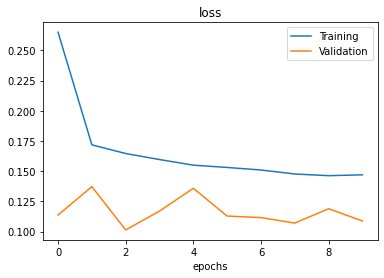

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title("loss")
plt.xlabel("epochs")

In [ ]:
model.save('model1.h5')

In [ ]:
from google.colab import files
files.download("model1.h5")